# Imports and initial basic data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import ast

#Import functions from `spectrum_helper_calcs.py`
import sys
sys.path.insert(0, '../')
from spectrum_helper_calcs import *

In [2]:
raw_data_directory = 'raw_data'
processed_dark_data_directory = 'processed_data'
processed_data_directory = 'processed_data'

start_index = 50
end_index = 998

integration_time_us = 8000

params_for_dark_data = { 'start_index' : start_index,
                         'end_index' : end_index,
                         'integration_time_us' : integration_time_us
                       }

# Function definitions

In [3]:
'''
Both dark data files and spectrum data files are assumed to be in the same directory, 
with all data files ending in `csv`
'''

def makename(datadirectory,filename):
    return os.path.join(datadirectory,filename)

def process_and_save_dark_data(raw_data_directory, processed_data_directory, params_for_dark_data):
    '''
    Calculate average dark data for data files in specified directory and save to csv file.
    
    Arguments:
        raw_data_directory - path to raw data directory
        processed_data_directory - path to directory in which to save processed data
        params_for_dark_data - dict with start_index, end_index (both mandatory), and any other desired parameters
            start_index, end_index - range of data to use
    
    Returns:
        Name and relative path of processed dark data file
    '''
    result = process_data(raw_data_directory, 
                          params_for_dark_data['start_index'], 
                          params_for_dark_data['end_index'], 
                          'dark')
    processed_dark_data_file = 'dark_2016-07-27.csv'
    params_for_dark_data['dark_data_file'] = processed_dark_data_file
    temp_name = makename(processed_data_directory, processed_dark_data_file)
    np.savetxt(temp_name, result, delimiter=',', header=str(params_for_dark_data))
    return temp_name

def process_data(data_directory, start_index, end_index, data_type):
    '''
    Calculate average spectrum data for data files in specified directory.
    
    Arguments:
        data_directory - directory in which raw data files reside
        start_index, end_index - range of data to use
        data_type - process dark data if data_type='dark' or 
                    spectrum data if data_type='spectrum'
    
    Returns:
        Numpy array with three columns: wavelength, average spectrum, standard deviation
    '''
    files = get_list_of_data_files(data_directory, data_type)
    return read_and_calc_ave_spectral_data(data_directory, files, start_index, end_index)

def get_list_of_data_files(datadirectory, datatype):
    '''
    Get list of raw data files (*.csv) in specified directory with specified type (dark or spectrum).
    
    Arguments:
        data_directory - directory in which raw data files reside
        data_type - dark data if data_type='dark' or 
                    spectrum data if data_type='spectrum'
    
    Returns:
        List of file names
    '''
    list_of_data_files = []
    for f in os.listdir(datadirectory):
        if f.endswith('csv'):
            if datatype == 'dark':
                if f.startswith('dark'):
                    list_of_data_files.append(f)
            elif datatype == 'spectrum':
                if not f.startswith('dark'):
                    list_of_data_files.append(f)
            else:
                raise ValueError('datatype argument must be "dark" or "spectrum". Instead it is' + datatype)
    return list_of_data_files

def read_and_calc_ave_spectral_data(datadirectory, filenames, start_index, end_index):
    """
    Read raw data from files in input list and return array with columns for wavelength, ave, std.
    Data in files is assumed to be in two columns, the first wavelength and the second spectrometer value
    
    Returns:
        Numpy array with three columns: wavelength, average spectrum, standard deviation
    """
    num_pnts_in_spectrum, num_data_files = (end_index-start_index), len(filenames)
    data_all = np.zeros(shape=(num_pnts_in_spectrum, num_data_files))
    for i, f in enumerate(filenames):
        temp_data = np.loadtxt(makename(datadirectory, f), delimiter=',')
        data_all[:,i] = temp_data[start_index:end_index, 1]
        if i is 0:
            wavelengths = temp_data[start_index:end_index, 0]
    ave = np.mean(data_all, axis=1)
    std = np.std(data_all, axis=1)
    return np.array([wavelengths, ave, std]).T

def get_processed_data_from_file(path_to_file):
    '''
    Retrieve processed spectrum data from specified file which can optionally have
    one comment line as the first line in the file.
    
    Arguments:
        path_to_file - relative path (including name) to processed data file
    
    Returns:
        header string - None if there is no header string
        numpy array with data. Columns are wavelength, spectrum, and (optionally) standard deviation
    '''
    # Read header line
    with open(path_to_file) as f:
        line = f.readline()
        li=line.strip()
        if li.startswith('#'):
            header = ast.literal_eval(li[2:])  # strip '# ' and convert to dict
        else:
            header = None
    # Read the rest of the file
    data = np.loadtxt(path_to_file, delimiter=',', dtype=float)
    return header, data

def process_and_save_spectrum_data(raw_data_directory, processed_data_directory, dark_data_file_name):
    '''
    Calculate average dark-corrected spectrum for data files in specified directory and save to csv file.
    
    Arguments:
        raw_data_directory - path to raw data directory
        processed_data_directory - path to directory in which to save processed data
        dark_data_file_name - file (including path) containing average dark data
    
    Returns:
        Name and relative path of processed spectrum data file
    '''
    ave_raw = process_data(raw_data_directory, 
                           params_for_dark_data['start_index'], 
                           params_for_dark_data['end_index'], 
                           'spectrum')
    dark_info, dark_data = get_processed_data_from_file(dark_data_file_name)
    ave_raw[:,1] -= dark_data[:,1]  # subtract dark data
    dark_info['max_value'] = np.max(ave_raw[:,1])
    ave_raw[:,1] /= dark_info['max_value']  # Normalize
    processed_spectrum_data_file = 'visitech_2016-07-27.csv'
    temp_name = makename(processed_data_directory, processed_spectrum_data_file)
    np.savetxt(temp_name, ave_raw, delimiter=',', header=str(params_for_dark_data))
    return temp_name

# Process dark data files

In [4]:
get_list_of_data_files(raw_data_directory, 'dark')

['dark (1).csv',
 'dark (10).csv',
 'dark (11).csv',
 'dark (12).csv',
 'dark (13).csv',
 'dark (14).csv',
 'dark (15).csv',
 'dark (16).csv',
 'dark (17).csv',
 'dark (18).csv',
 'dark (19).csv',
 'dark (2).csv',
 'dark (20).csv',
 'dark (3).csv',
 'dark (4).csv',
 'dark (5).csv',
 'dark (6).csv',
 'dark (7).csv',
 'dark (8).csv',
 'dark (9).csv']

In [5]:
# Process dark data and save to file
dark_data_file_name = process_and_save_dark_data(raw_data_directory, 
                                                 processed_dark_data_directory, params_for_dark_data)
print(dark_data_file_name)

processed_data/dark_2016-07-27.csv


# Process raw spectrum data files

In [6]:
get_list_of_data_files(raw_data_directory, 'spectrum')

['light_engine_spectra_1.csv',
 'light_engine_spectra_10.csv',
 'light_engine_spectra_11.csv',
 'light_engine_spectra_12.csv',
 'light_engine_spectra_13.csv',
 'light_engine_spectra_14.csv',
 'light_engine_spectra_15.csv',
 'light_engine_spectra_16.csv',
 'light_engine_spectra_17.csv',
 'light_engine_spectra_18.csv',
 'light_engine_spectra_19.csv',
 'light_engine_spectra_2.csv',
 'light_engine_spectra_20.csv',
 'light_engine_spectra_3.csv',
 'light_engine_spectra_4.csv',
 'light_engine_spectra_5.csv',
 'light_engine_spectra_6.csv',
 'light_engine_spectra_7.csv',
 'light_engine_spectra_8.csv',
 'light_engine_spectra_9.csv']

In [7]:
# Process raw spectrum data and save to file
spectrum_data_file_name = process_and_save_spectrum_data(raw_data_directory, 
                                                         processed_data_directory, 
                                                         dark_data_file_name)
print(spectrum_data_file_name)

processed_data/visitech_2016-07-27.csv


# Analyze and plot spectrum

In [9]:
# Load data
dark_info, dark_data = get_processed_data_from_file(dark_data_file_name)
spectrum_info, spectrum_data = get_processed_data_from_file(spectrum_data_file_name)

In [10]:
peak_Index = find_index_of_max(spectrum_data[:,1])
FWHM_indices = find_FWHM_indices(spectrum_data[:,1])
FWHM_nm = calc_FWHM_nm(spectrum_data)
print('             Index of emission peak:', peak_Index)
print('        Wavelength of emission peak:', spectrum_data[peak_Index,0])
print('Value at emission peak (normalized):', spectrum_data[peak_Index,1])
print('                          FWHM (nm):', FWHM_nm)
print('              Integration time (us):', spectrum_info['integration_time_us'])

             Index of emission peak: 195
        Wavelength of emission peak: 386.514347288
Value at emission peak (normalized): 1.0
                          FWHM (nm): 24.4929064211
              Integration time (us): 8000


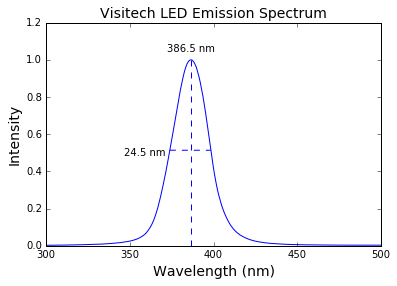

In [12]:
fig, ax = plt.subplots()

ax.plot(spectrum_data[:,0], spectrum_data[:,1])
ax.plot([spectrum_data[peak_Index,0], spectrum_data[peak_Index,0]], [0, spectrum_data[peak_Index,1]], 'b--')
ax.text(spectrum_data[peak_Index,0], 1.09, '{:5.1f} nm'.format(spectrum_data[peak_Index,0]),
        verticalalignment='top', horizontalalignment='center',
        transform=ax.transData)
ax.plot([spectrum_data[FWHM_indices[0],0], spectrum_data[FWHM_indices[1],0]], 
        [spectrum_data[FWHM_indices[0],1], spectrum_data[FWHM_indices[1],1]], 'b--')
ax.text(spectrum_data[FWHM_indices[0],0]-0.6*FWHM_nm, 0.5, '{:4.1f} nm'.format(FWHM_nm),
        verticalalignment='center', horizontalalignment='center',
        transform=ax.transData)

ax.set_xlim(300, 500)
ax.set_ylim(0, 1.2)
ax.set_xlabel('Wavelength (nm)', fontsize='14')
ax.set_ylabel('Intensity', fontsize='14')
ax.set_title('Visitech LED Emission Spectrum', fontsize='14')
#plt.savefig('visitech_spectrum.png')